# Assignment 2
#### Adam Judge - 16343971

## Task 1 - Data Collection

In [3]:
import numpy as np
import urllib.request
import bs4
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd 
pd.set_option("display.max_rows", None)
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

In [4]:
# Small function to obtain html parser
def getParser(url):
    # Request url page
    response = urllib.request.urlopen(url)
    if response.code != 200:
        print("Bad response!")
    # Decode HTML
    html = response.read().decode()    
    # Setup parser of html
    parser = bs4.BeautifulSoup(html, "html.parser")
    return parser

### A list of URLs will be generated through the extraction of the number of pages per month
From viewing the HTML, we can note that the h4 field contains the phase "Page 1 of X", which can be leveraged to obtain all data URLs.

In [5]:
# Get all URLS with data
# All urls start with this
urlBase="http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"
months=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
urls=[]
# Iterate through months
for m in months:
    # First URL of data per month
    url=urlBase + m + "-001.html"
    parser = getParser(url)
    # h4 field countains "Page 1 of X", extract X to obtain all urls with data
    for match in parser.find_all("h4"):
        text = match.get_text().split()
        # This will be the total number of pages to parse
        pagenum=int(text[-1])
    for num in range(1,pagenum+1):
        # Fit number into URL format
        if num<10:
            urls.append(urlBase+m+f"-00{num}.html")
        elif num<100:
            urls.append(urlBase+m+f"-0{num}.html")
        else:
            urls.append(urlBase+m+f"-{num}.html")

### Categories
##### The chosen categories for this assignment are Music, Sport, and US News. 
The titles, categories, and snippets will now be compiled into relevant lists

The h5 field contains the titles of the article snippets. These must be collected as required. The category of this title is then extracted along with the short text snippet for the story.

This data is then stored in a list of lists.

In [6]:
iter=0
# Categories of interest to the author
cats=["Music", "Sport", "US-News"]
# data[col][row]
# Multiclass array
dataAll=[]
# Arrays for binary
dataMusicSport=[]
dataMusicUSNews=[]
dataSportUSNews=[]
snippet=""
for u in urls:
    # Get HTML parser of each URL
    parser = getParser(u)
    titles=[]
    iter=0
    articleNum=0
    # Extract all titles on each URL
    for match in parser.find_all("h5"):
        # Strip number and period from start of titles
        titles.append(match.get_text().lstrip('0123456789. '))
    # p field contains category, times, snippets
    for match in parser.find_all("p"):
        text = match.get_text()
        currCat=text.split()[-1]
        # If category of interest and actually a category
        # Avoids snippets ending in category name
        if text.split()[0] == "Category:":
            articleNum+=1
        if currCat in cats and len(text.split())==2:
            category=currCat
            iter=1
            continue
        if iter == 0:
            # Times not needed
            continue
        if iter == 1:
            # Append titles, snippets, and categories to list of lists
            dataAll.append([titles[articleNum-1],text, category])
            # Add data and category to binary data sets
            if category == "Music" or category == "Sport":
                dataMusicSport.append([titles[articleNum-1], text, category])
            if category == "Music" or category == "US-News":
                dataMusicUSNews.append([titles[articleNum-1],text, category])
            if category == "Sport" or category == "US-News":
                dataSportUSNews.append([titles[articleNum-1],text, category])
            iter=0

The lists of lists of data are now converted to Dataframes. This is done primarily to view the data extracted,

In [7]:
cols=["Title", "Snippet", "Category"]
# Dataframe with all three categories
dfAll = pd.DataFrame(dataAll, columns=cols)
# Dataframes with binary combinations of categories
dfMS = pd.DataFrame(dataMusicSport, columns=cols)
dfMU = pd.DataFrame(dataMusicUSNews, columns=cols)
dfSU = pd.DataFrame(dataSportUSNews, columns=cols)

# Shuffle data to scramble data frames
dfAll = dfAll.sample(frac=1).reset_index(drop=True)
dfMS = dfMS.sample(frac=1).reset_index(drop=True)
dfMU = dfMU.sample(frac=1).reset_index(drop=True)
dfSU = dfSU.sample(frac=1).reset_index(drop=True)

# Print dataframe for all.
dfAll

ValueError: 2 columns passed, passed data had 3 columns

## Task 2
### Pre Processing Required
The dataframes have been shuffled to account for any biases which may effect the training/test data splits further on.

The snippets of articles often contain a large amount of irrelevant information, such as words containing little to no information gain such as "this", or "the". These may be removed through the use of CountVectorizer's default english stop_words.

The snippets of text will be converted to numeric representations through the counting and weighting of occurences of words. It is hoped that key words such as "golf" or "football" will allow for a sport document to be differentiated to a US-News document, which likely contains many mentions of key words such as "Trump" or "Election" due to the election year last year.

This representation method is known as Bag-of-Words representation.

In [6]:
# Transform data into list of strings of snippets and categories
dataAllSnips=[]
dataAllCats =[]
for tit, snip, cat in dataAll:
    dataAllSnips.append(snip)
    dataAllCats.append(cat)

dataMSSnips=[]
dataMSCats =[]
for tit, snip, cat in dataMusicSport:
    dataMSSnips.append(snip)
    dataMSCats.append(cat)
    
dataMUSnips=[]
dataMUCats =[]
for tit, snip, cat in dataMusicUSNews:
    dataMUSnips.append(snip)
    dataMUCats.append(cat)
    
dataSUSnips=[]
dataSUCats =[]
for tit, snip, cat in dataSportUSNews:
    dataSUSnips.append(snip)
    dataSUCats.append(cat)

#### The dataset containing Music and US-News will be used in the following sections

In [7]:
# Create vector
v = CountVectorizer()
# Parse terms into term frequencies
x=v.fit_transform(dataMSSnips)
terms=v.get_feature_names()
print(len(terms))

14027


Without using stop words this list of strings contains 14027 terms.
Using the english stop words:

In [8]:
# Remove stop words
vStop = CountVectorizer(stop_words="english")
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

13759


There are now 13759 terms, only a mild improvement. Removing sparsely used terms, i.e those used fewer than 5 times reduces the number dramatically

In [9]:
# Remove stop words and ignore occurences less than 5
vStop = CountVectorizer(stop_words="english", min_df=5)
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

2191


There are now 2191 terms which is a significant decrease in terms.
Generating TF-IDF weighted terms using TfidfVectorizer will give increased weighting to more frequent terms

In [10]:
# Weight terms
vStop = TfidfVectorizer(stop_words="english", min_df=5)
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

2191


It was decided to not utilise N-grams i.e sequence information will not be preserved. This is chosen so that the number of terms created is not too large. The chosen categories are likely to be seperated with a high degree of accuracy due to how different the categories are in practice. If US-News, UK-News, and Politics were chosen, then N-Gram methods may be more beneficial and practical.

The vectorizer chosen will remove single length tokens, as well as convert all tokens to lower case.

### Pipelines
Pipelines will allow for elegeant utilisation of cross validation, which will allow for accurate accuracy results with our model. A kNN classifier is used for the classification in this task.

The difference in accuracy is initially examed where the number of nearest neighbours is 3. This will be a constant. The optimal min_df number is found for the three pairs -  Music and Sport, Music and US-News, and Music and Sport. Ten fold cross validation is used so that the training/test data split does not effect the outcome drastically. Accuracy is sufficient for evaluation at this point.
### Music and Sport

In [11]:
# Setup pipeline
maxMin_df=10
#Accuracy storage for each df number
accMS=[]
accMU=[]
accSU=[]
for i in range(1,maxMin_df+1):
    # Create pipeline with stop words removed, using TFI-DF transform and kNN=3, vary min_df
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=i)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=3))])
    
    # Cross validate with 10 folds using the pipeline generated and each binary pair
    accMS_ = cross_val_score(p, dataMSSnips, dataMSCats, cv=10, scoring="accuracy")
    # Get the mean accuracy to remove influence of outliers
    accMS.append(accMS_.mean())
    
    accMU_ = cross_val_score(p, dataMUSnips, dataMUCats, cv=10, scoring="accuracy")
    accMU.append(accMU_.mean())
    
    accSU_ = cross_val_score(p, dataSUSnips, dataSUCats, cv=10, scoring="accuracy")
    accSU.append(accSU_.mean())

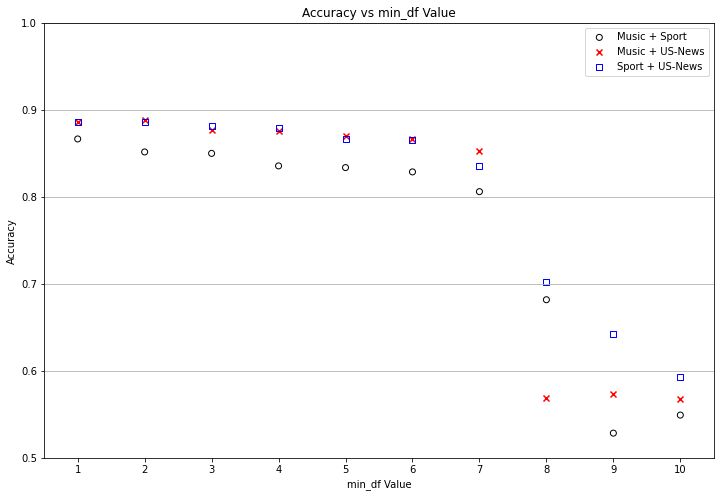

In [12]:
plt.figure(figsize=(12,8));
xAx=range(1,maxMin_df+1)
# Scatter plot of data
plt.scatter(xAx, accMS, marker="o", color="none", edgecolor="k", label="Music + Sport");
plt.scatter(xAx, accMU, marker="x", color="r", label="Music + US-News");
plt.scatter(xAx, accSU, marker="s", color="none",  edgecolor="b", label="Sport + US-News");
plt.legend()
plt.xlabel("min_df Value")
plt.ylabel("Accuracy")
plt.ylim([.5, 1])
plt.xlim([0.5, 10.5])
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid(axis="y")
plt.title("Accuracy vs min_df Value");

We can see that the accuracy alone is highest for low values of min_df, however setting a value of 5 results in a very large reduction in size and will be chosen. The accuracy declines fast after reducing terms occuring less than 8 times, meaning that terms occuring less than 8 times contain valuable information.

The effect of not using stop words is briefly explored also, using min_df=5 and k=3

In [13]:
accsw=[]
accnsw=[]
accdif=[]
# Generate pipeline without removing stop words
p1 = Pipeline([
    ('vec', CountVectorizer(min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))])
# Generate pipeline with removing stop words
p2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

# Accuracies from 10 fold cross validation on Music + Sport without removing stop words
accMS_nosw = cross_val_score(p1, dataMSSnips, dataMSCats, cv=10, scoring="accuracy")
# Accuracies from 10 fold cross validation on Music + Sport with removing stop words
accMS_sw = cross_val_score(p2, dataMSSnips, dataMSCats, cv=10, scoring="accuracy")
accsw.append(accMS_nosw.mean())
accnsw.append(accMS_nosw.mean())
# Calculate differences
accdif.append(accMS_nosw.mean()-accMS_nosw.mean())

accMU_nosw = cross_val_score(p1, dataMUSnips, dataMUCats, cv=10, scoring="accuracy")
accMU_sw = cross_val_score(p2, dataMUSnips, dataMUCats, cv=10, scoring="accuracy")
accsw.append(accMU_nosw.mean())
accnsw.append(accMU_nosw.mean())
accdif.append(accMU_nosw.mean()-accMU_nosw.mean())

accSU_nosw = cross_val_score(p1, dataSUSnips, dataSUCats, cv=10, scoring="accuracy")
accSU_sw = cross_val_score(p2, dataSUSnips, dataSUCats, cv=10, scoring="accuracy")
accsw.append(accSU_nosw.mean())
accnsw.append(accSU_nosw.mean())
accdif.append(accSU_nosw.mean()-accSU_nosw.mean())

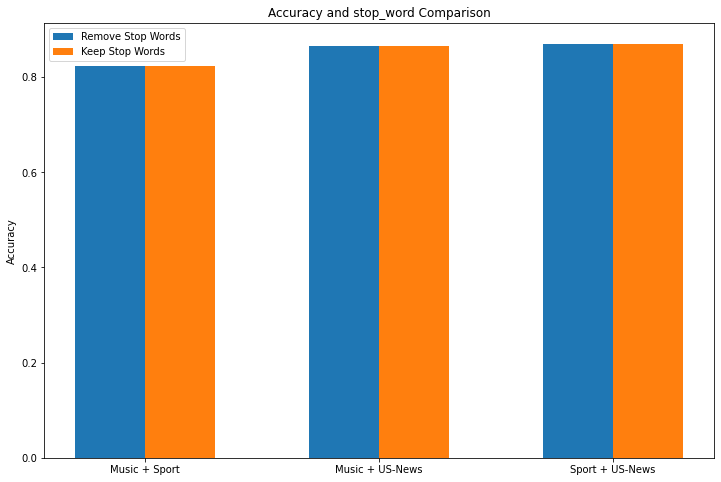

In [14]:
# Plot bar charts
plt.figure(figsize=(12,8))
w=0.3
xlabels=["Music + Sport", "Music + US-News", "Sport + US-News"]
x=np.arange(len(xlabels))
plt.bar(x-w/2, accsw, w, label="Remove Stop Words")
plt.bar(x+w/2, accnsw, w, label="Keep Stop Words")
plt.xticks(x,xlabels);
plt.ylabel("Accuracy")
plt.title("Accuracy and stop_word Comparison")
plt.legend();

There is practically no discernable difference in accuracy and the use of stop words on these data sets. The default English stop words will be removed in any case.

The effect of the number of nearest neighbours will now be explored with min_df=5. An estimate for the expected value of k is often near the square root of the total number of elements.

In [15]:
# Setup pipeline
kMax=100
accMS=[]
accMU=[]
accSU=[]
# Iterate every 5 neighbours up to limit
for i in range(5,kMax+1,5):
    # Generate pipeline with min_df=5, TFI_DF transform, kNN=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=5)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=i))])
    
    # 10 fold cross validation on Music + Sport
    accMS_ = cross_val_score(p, dataMSSnips, dataMSCats, cv=10, scoring="accuracy")
    accMS.append(accMS_.mean())
    
    accMU_ = cross_val_score(p, dataMUSnips, dataMUCats, cv=10, scoring="accuracy")
    accMU.append(accMU_.mean())
    
    accSU_ = cross_val_score(p, dataSUSnips, dataSUCats, cv=10, scoring="accuracy")
    accSU.append(accSU_.mean())

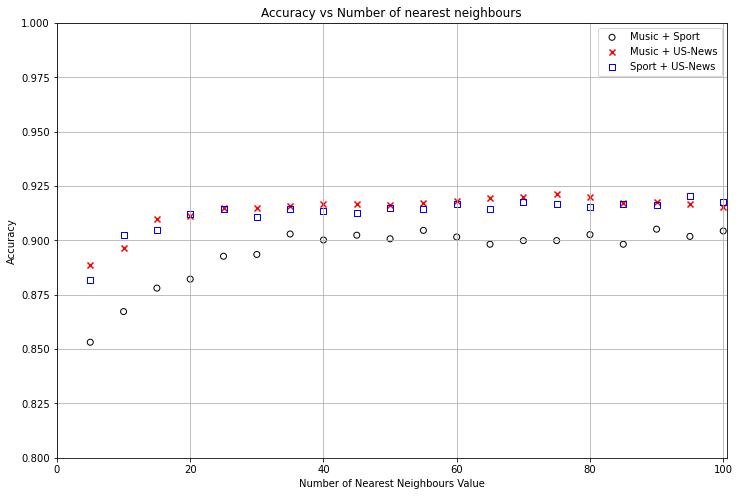

In [16]:
# Plot accuracies for all binary classifiers with varying k
plt.figure(figsize=(12,8));
xAx=range(5,kMax+1,5)
plt.scatter(xAx, accMS, marker="o", color="none", edgecolor="k", label="Music + Sport");
plt.scatter(xAx, accMU, marker="x", color="r", label="Music + US-News");
plt.scatter(xAx, accSU, marker="s", color="none",  edgecolor="b", label="Sport + US-News");
plt.legend()
plt.xlabel("Number of Nearest Neighbours Value")
plt.ylabel("Accuracy")
plt.ylim([.8, 1])
plt.xlim([0.5, kMax+.5])
plt.xticks([0,20,40,60,80,100])
plt.grid()
plt.title("Accuracy vs Number of nearest neighbours");

In [17]:
X=accMS.index(max(accMS))*5
Y=accMU.index(max(accMU))*5
Z=accSU.index(max(accSU))*5
print(f"The highest accuracy is obtained from the number of nearest neighbours being {X} for Music and Sport, {Y} for Music and US-News, and {Z} for Sport and US-News.")
print(f"These result inaccuracies of {round(max(accMS)*100,2)}%, {round(max(accMU)*100,2)}%, {round(max(accSU)*100,2)}% respectively")

The highest accuracy is obtained from the number of nearest neighbours being 85 for Music and Sport, 70 for Music and US-News, and 90 for Sport and US-News.
These result inaccuracies of 90.51%, 92.11%, 92.05% respectively


Viewing the confusion matrices of these specific models will help in determining if the model is producing good outputs, i.e that it is not assigning to a majority class for example and ignoring one class entirely.

In [18]:
# Create KNN classifier with respective max accuracies at time of running.
# These values should be close to the optimal values over subsequent runs of this program
m_MS=KNeighborsClassifier(n_neighbors=85)
m_MU=KNeighborsClassifier(n_neighbors=70)
m_SU=KNeighborsClassifier(n_neighbors=90)

# Split data into 80 20 training test
MS_train_docs, MS_test_docs, MS_train_target, MS_test_target = train_test_split(dataMSSnips, dataMSCats, test_size=0.2)
MU_train_docs, MU_test_docs, MU_train_target, MU_test_target = train_test_split(dataMUSnips, dataMUCats, test_size=0.2)
SU_train_docs, SU_test_docs, SU_train_target, SU_test_target = train_test_split(dataSUSnips, dataSUCats, test_size=0.2)

# Get vector with stop words removed and min_df=5
vms= TfidfVectorizer(stop_words="english", min_df=5)
# Transform vector to fit training doc
XMS= vms.fit_transform(MS_train_docs)
# Preprocess test data the same way
XMS_test = vms.transform(MS_test_docs)
# Train the model with the training data and targets
m_MS.fit(XMS, MS_train_target)
# Predict test data
MS_predictions=m_MS.predict(XMS_test)
# Get probability of prediction
MS_predictions_prob=m_MS.predict_proba(XMS_test)[:,1]
# Get AUC
MS_AUC=roc_auc_score(MS_test_target,MS_predictions_prob)
# Get confusion matrix
cm_MS = confusion_matrix(MS_test_target, MS_predictions, labels=["Music", "Sport"])
print("Music - Sport Confusion Matrix:")
print(cm_MS)
print(f"Music - Sport AUC: {MS_AUC}")

# Get vector with stop words removed and min_df=5
vmu= TfidfVectorizer(stop_words="english", min_df=5)
# Transform vector to fit training doc
XMU= vmu.fit_transform(MU_train_docs)
# Preprocess test data the same way
XMU_test = vmu.transform(MU_test_docs)
# Train the model with the training data and targets
m_MU.fit(XMU, MU_train_target)
# Predict test data
MU_predictions=m_MU.predict(XMU_test)
# Get probability of prediction
MU_predictions_prob=m_MU.predict_proba(XMU_test)[:,1]
# Get AUC
MU_AUC=roc_auc_score(MU_test_target, MU_predictions_prob)
# Get confusion matrix
cm_MU = confusion_matrix(MU_test_target, MU_predictions, labels=["Music", "US-News"])
print("Music - US-News Confusion Matrix:")
print(cm_MU)
print(f"Music - US-News AUC: {MU_AUC}")

# Get vector with stop words removed and min_df=5
vsu= TfidfVectorizer(stop_words="english", min_df=5)
# Transform vector to fit training doc
XSU= vsu.fit_transform(SU_train_docs)
# Preprocess test data the same way
XSU_test = vsu.transform(SU_test_docs)
# Train the model with the training data and targets
m_SU.fit(XSU, SU_train_target)
# Predict test data
SU_predictions=m_SU.predict(XSU_test)
# Get probability of prediction
MU_predictions_prob=m_SU.predict_proba(XSU_test)[:,1]
# Get AUC
SU_AUC=roc_auc_score(SU_test_target, MU_predictions_prob)
# Get confusion matrix
cm_SU = confusion_matrix(SU_test_target, SU_predictions, labels=["Sport", "US-News"])
print("Sport - US-News Confusion Matrix:")
print(cm_SU)
print(f"Sport - US-News AUC: {SU_AUC}")


Music - Sport Confusion Matrix:
[[333  26]
 [ 28 337]]
Music - Sport AUC: 0.9760560155683596
Music - US-News Confusion Matrix:
[[330  35]
 [ 32 326]]
Music - US-News AUC: 0.9725721282620341
Sport - US-News Confusion Matrix:
[[346  38]
 [ 24 319]]
Sport - US-News AUC: 0.970310222303207


There are roughly as many type 1 errors as type 2 and predictions are not being made to any majority class as there is clearly no majority class present here. There is a low number of false negatives and false positives, with amounts reflecting the accuracy of our models

The achieved accuracy levels of 90.51%, 92.11%, and 92.05% show that these models are very good at discerning snippets of text pertaining to a specific category of text. The additional pre-processing and exploration has yielded an accuracy gain of over 10%

Finally the AUC for all three binary classifiers is very high, over 0.96 for all. A value of 0.9 or more indicates a very strong classifier.

## Task 3
The steps undertaken for comparing all three categories is broadly similar.
kNN will be explored as well as Stochastic Gradient Descent as our methods of multiclass classification.
### kNN
The same min_df of 5 will be used, with the default English stop_words being removed from the document.
Exploring the accuracy through varying k:

In [19]:
# Setup pipeline
maxk=100
acc=[]
for i in range(5,maxk+1,5):
    # Pipeline with min_df=5, stop words removed, and kNN classifier with k=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=5)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=i))])
    # 10 fold cross validation accuracy
    acc_ = cross_val_score(p, dataAllSnips, dataAllCats, cv=10, scoring="accuracy")
    acc.append(acc_.mean())

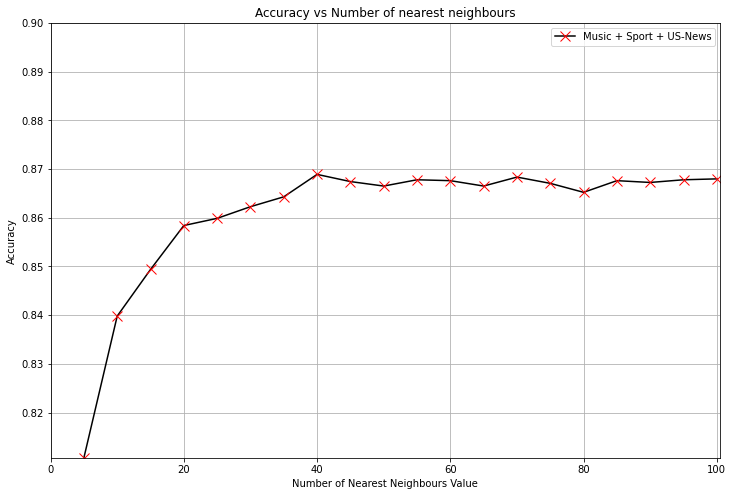

In [20]:
# Plot accuracies of multi class over range of k
plt.figure(figsize=(12,8));
xAx=range(5,maxk+1,5)
plt.plot(xAx, acc,'k', marker="x", markeredgecolor="r",ms=10, label="Music + Sport + US-News");
plt.legend()
plt.xlabel("Number of Nearest Neighbours Value")
plt.ylabel("Accuracy")
plt.ylim([min(acc), .9])
plt.xlim([0.5, kMax+.5])
plt.xticks([0,20,40,60,80,100])
plt.grid()
plt.title("Accuracy vs Number of nearest neighbours");

In [21]:
X=acc.index(max(acc))*5
print(f"The highest accuracy is obtained from the number of nearest neighbours is {X} for Music, Sport, and US-News")
print(f"This result in accuracies of {round(max(acc)*100,2)}%")

The highest accuracy is obtained from the number of nearest neighbours is 35 for Music, Sport, and US-News
This result in accuracies of 86.89%


The highest accuracy is observed where k is around 35. This results in an accuracy of 86.89%, lower than binary classifications as would be expected due to the increased complexity of the problem.

### Stochastic Gradient Descent
As with kNN, a pipeline will be created with the same parameters, except the SGDClassifier will be used instead for classification.

In [22]:
# Stochastic gradient descent pipeline with stop words removed, min_df=5, TFI-DF transform
psgd = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
acc_sgd = cross_val_score(psgd, dataAllSnips, dataAllCats, cv=10, scoring="accuracy")
accsgd=acc_sgd.mean()
print(f"The accuracy achieved with SGD is {round(accsgd,2)*100}%")

The accuracy achieved with SGD is 88.0%


The accuracy with SGD appears to be higher by just over 1% over consecutive runs. 

## Model Decision
Comparing the confusion matrices will allow for us to determine if the SGD is indeed better than our kNN model. AUC is not used as confusion matrices are better for multiclass evaluation


In [23]:
#SGD classifier
m_SGD=SGDClassifier(loss="log")
#kNN classifier
m_kNN=KNeighborsClassifier(n_neighbors=35)

# Split data into 80 20 training test
train_docs, test_docs, train_target, test_target = train_test_split(dataAllSnips, dataAllCats, test_size=0.2)

# Get vector with stop words removed and min_df=5
vall= TfidfVectorizer(stop_words="english", min_df=5)
# Transform vector to fit training doc
Xall= vall.fit_transform(train_docs)
# Preprocess test data the same way
Xall_test = vall.transform(test_docs)
# Train the model with the training data and targets
m_SGD.fit(Xall, train_target)
m_kNN.fit(Xall, train_target)
# Predict test data
SGD_predictions=m_SGD.predict(Xall_test)
kNN_predictions=m_kNN.predict(Xall_test)

# Get confusion matrix
cm_SGD = confusion_matrix(test_target, SGD_predictions, labels=["Music", "Sport", "US-News"])
cm_kNN = confusion_matrix(test_target, kNN_predictions, labels=["Music", "Sport", "US-News"])
print("SGD Confusion Matrix:")
print(cm_SGD)
print("kNN Confusion Matrix:")
print(cm_kNN)


SGD Confusion Matrix:
[[294  25  18]
 [ 18 333  13]
 [ 26  23 337]]
kNN Confusion Matrix:
[[286  26  25]
 [ 42 302  20]
 [ 29  20 337]]


## Conclusion
Both models possess good quality confusion matrices with no majority classes selected with low levels of false positives/negatives. From this, the SGD method of multiclass classification is our preferred method.

From the above confusion matrix, the classifier is better at categorizing US-News from Sport and Music as can be seen by the higher TP rate in the lower right hand corner of the confusion matrix relative to the other two TP values. This was expected as this category is more distinct compared to Music and Sport. The abundance of mentions of Trump and Biden in the dataset no doubt made it easier for the classifier.

Sport and music are broadly similar, with Music being the most difficult to categorise out of the three categories.

The generated model is able to categorize with an accuracy of approximately 88% from small snippets of articles.